# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [0]:
# Uncomment and run these in Colab
# %tensorflow_version 1.x
# !pip install --upgrade opencv-python==3.4.2.17

In [0]:
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

print(tf.__version__)
print('Libraries Imported')

1.15.2
Libraries Imported


In [0]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')
dir = "/content/drive/My Drive/Datasets/"
files = os.listdir(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
zip_ref = zipfile.ZipFile(dir + 'all_emojis.zip', 'r')
zip_ref.extractall("/tmp/")
zip_ref.close()
zip_ref = zipfile.ZipFile(dir + 'filtered_emojis.zip', 'r')
zip_ref.extractall("/tmp/")
zip_ref.close()

### Tips and Tricks
https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/  
https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

In [0]:
ROLLNUMBER = 20100120
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2500
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Deep Learning/Models/'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = '/tmp/filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<!-- <br>
![DCGAN Discriminator](DCGAN_disc.png)
<br> -->

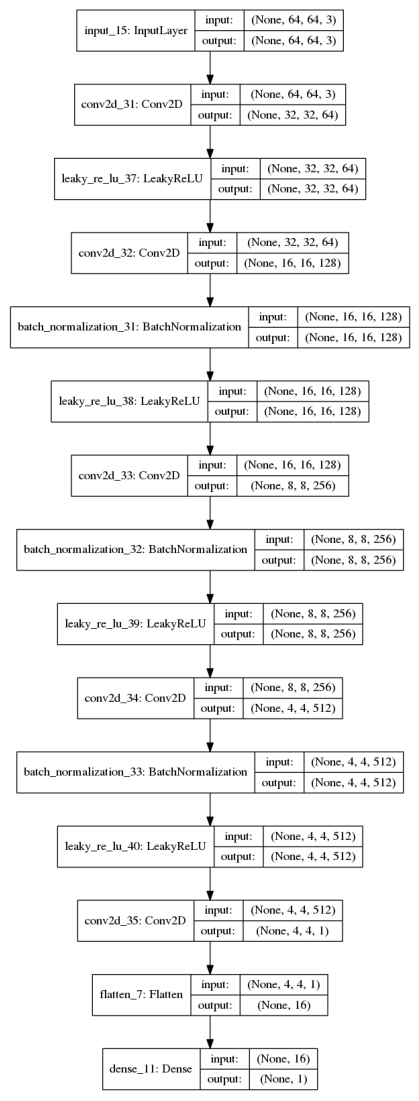

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
img = mpimg.imread(dir + 'DCGAN_disc.png')
plt.axis('off')
plt.grid(b=None)
plt.imshow(img)

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [0]:
def build_discriminator():
    input = Input(shape=(64,64,3))

    x = Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False)(input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    output = Dense(1, activation= 'sigmoid')(x)

    model = Model(inputs = input, outputs = output)
    return model

### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<!-- <br>
![DCGAN Generator](DCGAN_gen.png) -->

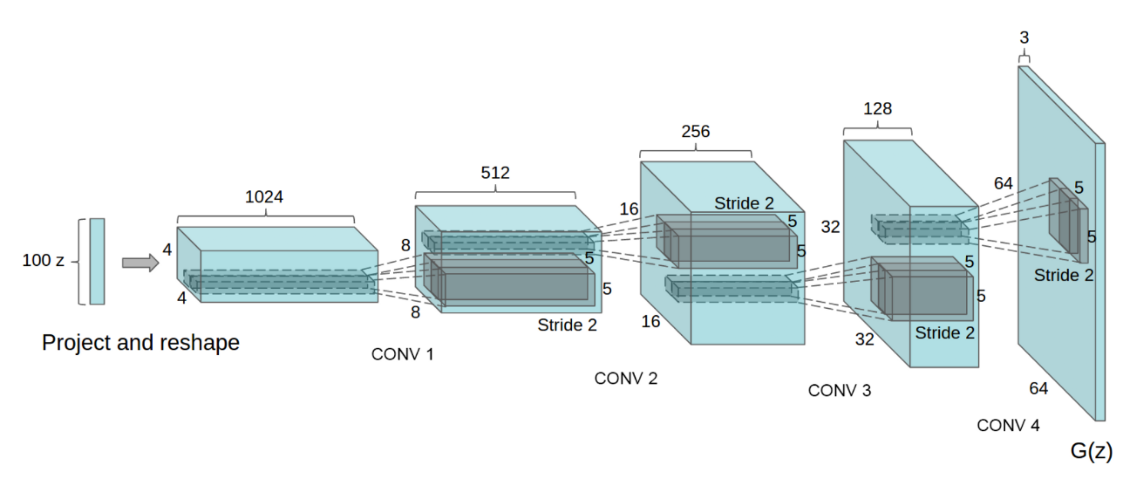

In [0]:
plt.figure(figsize=(20,20))
img = mpimg.imread(dir + 'DCGAN_GEN.png')
plt.axis('off')
plt.grid(b=None)
plt.imshow(img)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [0]:
def build_generator():
    input = Input(shape=(NOISE_DIM,))

    x = Dense(4*4*1024)(input)
    x = Reshape((4,4,1024))(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name = 'relu_activation_1')(x)

    x = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name = 'relu_activation_2')(x)

    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name = 'relu_activation_3')(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name = 'relu_activation_4')(x)

    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    output = Activation('tanh', name = 'tanh_activation')(x)

    model = Model(inputs= input, outputs= output)
    return model

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [0]:
G = build_generator()
opt = Adam(lr=0.0001, beta_1=0.9, decay=8e-8)
G.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
G.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 1024)        4096      
_________________________________________________________________
relu_activation_1 (Activatio (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         4719104   
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 512)         2048

In [0]:
D = build_discriminator()
opt = Adam(lr=0.0001, beta_1=0.9, decay=8e-8)
D.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
D.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4800      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_______________________________

In [0]:
def build_gan(gen,disc):
  disc.trainable = False
  DCGAN = Sequential([gen, disc])
  DCGAN.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=opt)
  return DCGAN

DC_GAN = build_gan(G, D)
DC_GAN.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 64, 64, 3)         7859983   
_________________________________________________________________
model_2 (Model)              (None, 1)                 4322005   
Total params: 12,181,988
Trainable params: 7,856,137
Non-trainable params: 4,325,851
_________________________________________________________________


Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [0]:
def save_samples(generated_images,step,save_at="Samples/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [0]:
def gen_random_sample(sample_size=32):
    rand = np.random.normal(0, 1, size =(sample_size,NOISE_DIM))
    return rand

In [0]:
load = load_data()
load.shape

(725, 64, 64, 3)

In [0]:
batches_per_epoch = int(load.shape[0] / BATCH_SIZE)
total_iterations = batches_per_epoch * EPOCHS
print('Batches per Epoch: ',batches_per_epoch)
print('Total Iterations: ', total_iterations)

Batches per Epoch:  5
Total Iterations:  12500


Next, we can see that one iteration of training results in possibly multiple updates to the discriminator and one update to the generator

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here

            batch_x_real = X_train[index : index + BATCH_SIZE]

            z = sample_noise()
            batch_x_fake = G.predict_on_batch(z)

            batch_y_real = np.ones(shape=(BATCH_SIZE,))
            batch_y_fake = np.zeros(shape=(BATCH_SIZE,))

            disc_loss = (D.train_on_batch(batch_x_real, batch_y_real))[0]
            disc_loss += (D.train_on_batch(batch_x_fake, batch_y_fake))[0]
            
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch
            gen_loss =  (DC_GAN.train_on_batch(z, batch_y_real))[0]

            epoch_gen_loss.append(gen_loss)

            if not (e % intervals):
                save_samples(batch_x_fake,e)

            progress_bar.update(i+1)
        if not (e % intervals):
            # Save weights here
            D.save_weights(BASE_DIR + 'Discriminator/' + 'model_' + str(e) + '.hdf5')
            G.save_weights(BASE_DIR + 'Generator/' + 'model_' + str(e) + '.hdf5')
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell

In [0]:
D_Loss, G_Loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
Epoch: 1 | Discriminator Loss: 0.326931 | Generator Loss: 0.026448
5/5 [==============================] - 2s 314ms/step
Epoch: 2 | Discriminator Loss: 0.326901 | Generator Loss: 0.026022
5/5 [==============================] - 2s 304ms/step
Epoch: 3 | Discriminator Loss: 0.326895 | Generator Loss: 0.026375
5/5 [==============================] - 2s 304ms/step
Epoch: 4 | Discriminator Loss: 0.326829 | Generator Loss: 0.025887
5/5 [==============================] - 2s 303ms/step
Epoch: 5 | Discriminator Loss: 0.326805 | Generator Loss: 0.025658
5/5 [==============================] - 2s 305ms/step
Epoch: 6 | Discriminator Loss: 0.326713 | Generator Loss: 0.025017
5/5 [==============================] - 2s 303ms/step
Epoch: 7 | Discriminator Loss: 0.326665 | Generator Loss: 0.024842
5/5 [==============================] - 2s 304ms/step
Epoch: 8 | Discriminator Loss: 0.326642 | Generator Loss: 0.024426
5/5 [==============================] - 2s 

### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

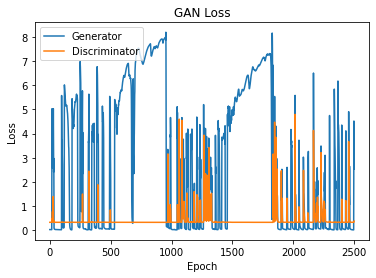

In [0]:
plot_loss(G_Loss, D_Loss)

**Answer** From the generator and discriminator loss we can see that the loss keeps on fluctuating for both as the generator is unable to generate images to fool the the discriminator and the discriminator because of bad generated images doesnt improve itself and with no real weight improvement still manages to discriminate properly real from fake thus giving a very low loss for the discriminator 

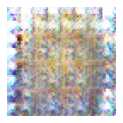

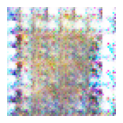

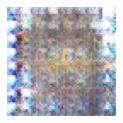

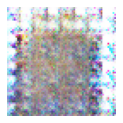

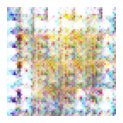

In [0]:
z = np.random.normal(0, 1, size =(5,NOISE_DIM))
batch_x_fake = G.predict_on_batch(z)
for i in range(batch_x_fake.shape[0]):
  img = k_image.array_to_img(batch_x_fake[i])
  plt.figure(figsize=(2,2))
  plt.axis('off')
  plt.grid(b=None)
  plt.imshow(img)

**Answer** We can see in Part 1 that or samples are not as we expected them to turn out. This is because there were alot of things we didnt do the most important being we didnt convert the images in ranges from [-1,1] which leads to failures in our samples 

## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [0]:
def build_discriminator2():
  input = Input(shape=(64,64,3))

  x = Conv2D(64, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(512, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(1, kernel_size=5, strides=1, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Flatten()(x)
  output = Dense(1, activation= 'sigmoid')(x)

  model = Model(inputs = input, outputs = output)
  return model

In [0]:
DIS = build_discriminator2()
opt = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
DIS.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
DIS.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4800      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (L

In [0]:
def build_generator2():
  input = Input(shape=(NOISE_DIM,))

  x = Dense(4*4*1024)(input)
  x = Reshape((4,4,1024))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(512, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
  x = BatchNormalization()(x)
  output = Activation('tanh', name = 'tanh_activation')(x)

  model = Model(inputs= input, outputs= output)
  return model

In [0]:
GEN = build_generator2()
opt = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
GEN.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
GEN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 512)         2048

In [0]:
def build_gan(gen,disc):
  disc.trainable = False
  GAN = Sequential([gen, disc])
  GAN.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=opt)
  return GAN

DCGAN = build_gan(GEN, DIS)
DCGAN.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 64, 64, 3)         18875276  
_________________________________________________________________
model_1 (Model)              (None, 1)                 4322005   
Total params: 23,197,281
Trainable params: 18,871,430
Non-trainable params: 4,325,851
_________________________________________________________________


### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [0]:
def normalize(images):
  return (images - 127.5) / 127.5

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [0]:
def random_noise():
  return np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [0]:
def smooth_real_labels():
  return np.random.uniform(0.7,1.2,BATCH_SIZE)

#### Fake Label Smoothing

In [0]:
def smooth_fake_labels():
    return np.zeros(shape=(BATCH_SIZE,))

We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [0]:
def save_samples(generated_images,step,save_at="Samples/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'improved_generated_image_' + str(step) + '.png'))

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    X_train = load_data()
    X_train = normalize(X_train)
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here

            batch_x_real = X_train[index : index + BATCH_SIZE]

            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            batch_x_fake = GEN.predict_on_batch(z)

            batch_y_real = np.random.uniform(0.7,1.2,BATCH_SIZE)
            batch_y_fake = np.zeros(shape=(BATCH_SIZE,))

            disc_loss = (DIS.train_on_batch(batch_x_real, batch_y_real))[0]
            disc_loss += (DIS.train_on_batch(batch_x_fake, batch_y_fake))[0]
            
            epoch_disc_loss.append(disc_loss)
            
            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            if np.random.uniform(0,1) > 0.2:
              gen_loss =  (DCGAN.train_on_batch(z, batch_y_real))[0]
            else:
              gen_loss =  (DCGAN.train_on_batch(z, batch_y_fake))[0]

            epoch_gen_loss.append(gen_loss)

            if not (e % intervals):
                save_samples(batch_x_fake,e)

            progress_bar.update(i+1)
        if not (e % intervals):
            # Save weights here
            DIS.save_weights(BASE_DIR + 'Discriminator/' + 'imp_model_' + str(e) + '.hdf5')
            GEN.save_weights(BASE_DIR + 'Generator/' + 'imp_model_' + str(e) + '.hdf5')
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
DLoss, GLoss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
Epoch: 1 | Discriminator Loss: 0.255532 | Generator Loss: 2.154284
5/5 [==============================] - 6s 1s/step
Epoch: 2 | Discriminator Loss: 0.246393 | Generator Loss: 2.024114
5/5 [==============================] - 6s 1s/step
Epoch: 3 | Discriminator Loss: 0.235097 | Generator Loss: 2.380952
5/5 [==============================] - 6s 1s/step
Epoch: 4 | Discriminator Loss: 0.209678 | Generator Loss: 1.774162
5/5 [==============================] - 6s 1s/step
Epoch: 5 | Discriminator Loss: 0.243850 | Generator Loss: 1.898974
5/5 [==============================] - 6s 1s/step
Epoch: 6 | Discriminator Loss: 0.220136 | Generator Loss: 2.221645
5/5 [==============================] - 6s 1s/step
Epoch: 7 | Discriminator Loss: 0.224114 | Generator Loss: 1.802690
5/5 [==============================] - 6s 1s/step
Epoch: 8 | Discriminator Loss: 0.213489 | Generator Loss: 1.971375
5/5 [==============================] - 6s 1s/step
Epoch: 9 | Di

In [0]:
def gan_training_loop2(intervals=200):
    # Setup Models here
    X_train = load_data()
    X_train = normalize(X_train)
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS+1, (EPOCHS+1)+800):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here

            batch_x_real = X_train[index : index + BATCH_SIZE]

            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            batch_x_fake = GEN.predict_on_batch(z)

            batch_y_real = np.random.uniform(0.7,1.2,BATCH_SIZE)
            batch_y_fake = np.zeros(shape=(BATCH_SIZE,))

            disc_loss = (DIS.train_on_batch(batch_x_real, batch_y_real))[0]
            disc_loss += (DIS.train_on_batch(batch_x_fake, batch_y_fake))[0]
            
            epoch_disc_loss.append(disc_loss)
            
            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            gen_loss =  (DCGAN.train_on_batch(z, batch_y_real))[0]

            epoch_gen_loss.append(gen_loss)

            if not (e % intervals):
                save_samples(batch_x_fake,e)

            progress_bar.update(i+1)
        if not (e % intervals):
            # Save weights here
            DIS.save_weights(BASE_DIR + 'Discriminator/' + 'imp_model_' + str(e) + '.hdf5')
            GEN.save_weights(BASE_DIR + 'Generator/' + 'imp_model_' + str(e) + '.hdf5')
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
D2Loss, G2Loss = gan_training_loop2()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 6s 1s/step
Epoch: 2502 | Discriminator Loss: 0.247111 | Generator Loss: 5.293675
5/5 [==============================] - 6s 1s/step
Epoch: 2503 | Discriminator Loss: 0.215630 | Generator Loss: 4.991689
5/5 [==============================] - 6s 1s/step
Epoch: 2504 | Discriminator Loss: 0.184557 | Generator Loss: 5.188669
5/5 [==============================] - 6s 1s/step
Epoch: 2505 | Discriminator Loss: 0.204585 | Generator Loss: 5.047842
5/5 [==============================] - 6s 1s/step
Epoch: 2506 | Discriminator Loss: 0.190970 | Generator Loss: 5.048838
5/5 [==============================] - 6s 1s/step
Epoch: 2507 | Discriminator Loss: 0.254585 | Generator Loss: 4.752982
5/5 [==============================] - 6s 1s/step
Epoch: 2508 | Discriminator Loss: 0.216887 | Generator Loss: 5.041212
5/5 [==============================] - 6s 1s/step
Epoch: 2509 | Discriminator Loss: 0.184801 | Generator Loss: 4.905027
5/5 [==============================] - 6

In [0]:
# GEN.load_weights(BASE_DIR + 'Generator/imp_model_3200.hdf5')

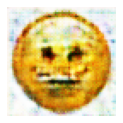

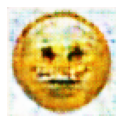

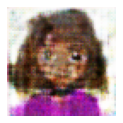

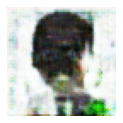

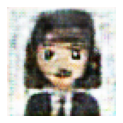

In [0]:
z = np.random.normal(0, 1, size =(5,NOISE_DIM))
batch_x_fake = GEN.predict_on_batch(z)
for i in range(batch_x_fake.shape[0]):
  img = k_image.array_to_img(batch_x_fake[i])
  plt.figure(figsize=(2,2))
  plt.axis('off')
  plt.grid(b=None)
  plt.imshow(img)

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images

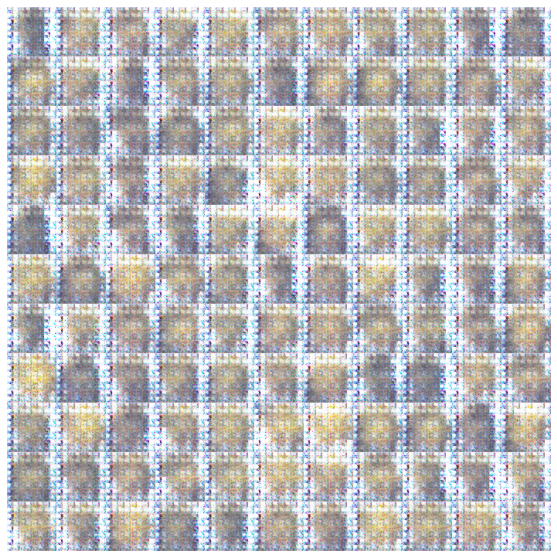

In [0]:
plt.figure(figsize=(10,10))
img = mpimg.imread(BASE_DIR + 'Samples/generated_image_2200.png')
plt.axis('off')
plt.grid(b=None)
plt.imshow(img)

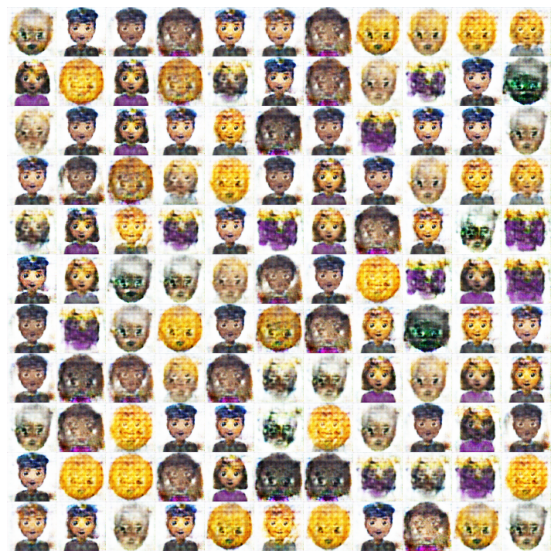

In [0]:
plt.figure(figsize=(10,10))
img = mpimg.imread(BASE_DIR + 'Samples/improved_generated_image_3301.png')
plt.axis('off')
plt.grid(b=None)
plt.imshow(img)

## **ANALYSIS:**

As we can see in Part 1, it clearly shows a mode collapse.Mode collapse is when the GAN produces a small variety of images with many duplicates (modes). This happens when the generator is unable to learn a rich feature representation because it learns to associate similar outputs to multiple different inputs. To check for mode collapse, inspect the generated images. If there is little diversity in the output and some of them are almost identical, then there is likely mode collapse

For part 1 we can also see that the Discriminator loss remains close to 0 the entire time and the generator loss keeps on fluctuating. This means that the discriminator is dominating, because the initial generated images are very poor it is very easy for the discriminator to get fooled and thus we never reach a balance between the two. This we can see is later countered by the idea of once in a while flipping the labels. This failure mode is termed as convergence failure .

Firstly we can see that there are a lot of differences between the two discriminator and the two generators as they the generatore and disctiminator in part 2 created much better emoji generated images than of those generated images in part 1 this could be mainly due to the modified methods used in training both our models (Generator and Discriminator). In the first part we can see that we have not normalised ourr image and that we are training we don't use the kernel initialiser for the weight initialisation with a mean of 0 and standard deviation of 0.02. For the first part we also used leaky relu in our discriminator and relu in the generator and tanh for the output of the generator and we use batch normalisation in both the discriminator and the generator. The new modifications made to part 2 is that we used leaky relu in both the generator and the discriminator, used weight initialisation with the mean of 0 and standard deviation of 0.02 you and we used the Adam optimizer with learning rate of 0.0002 beta 1 of 0.5 and decay of 8e-8, which many people had sited as better than 0.0001 learning rate and 0.9 beta 1 in their papers. We also used the guassian distribution for our random noise with a mean of 0 and std of 1 which was better than our formerly used random distribution in part 1. When I say we normalized the image that means I brought it into the range [-1,1] whichI think created a significant difference in the two generatyed images. We also changed the labels to soft or smooth labels that means that we instead of keeping the real hard label 1 for real and 0 for fake as done in part one we gave our real batch soft label i.e a uniform distribution between 0.7 and 1.2 and as for the fake labels they remained zero.
Another thing is alot of papers suggested to use bigger kernel sizes, so in my part 2 instead of 4 I used a kernel size of 5x5. In part 2, I also generated two different oise samples, and fed one to the discriminator and one to the generator. Further more I flipped the labels for the batch with a probability of 0.8 for keeping the original labels and 0.2 for flipping the labels. I run this like this a few times and when I know that the discriminator can be fooled without using this technique, I then revert back keeping the same labels giving much clearer emojis. I did run it a few extra times for better results. All these modifications looking at the results above shows the they help in generating better images. 

#### Part 1 Generated Images Flow

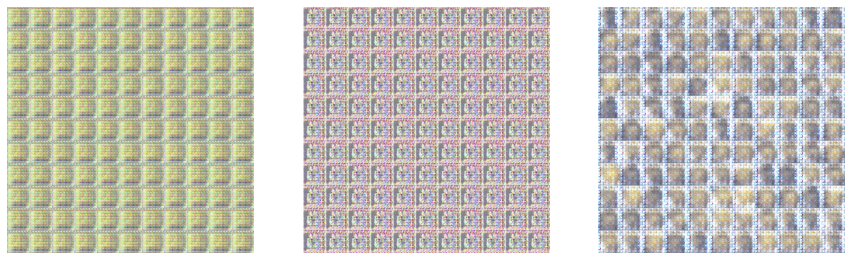

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
img = mpimg.imread(BASE_DIR + 'Samples/generated_image_400.png')
img2 = mpimg.imread(BASE_DIR + 'Samples/generated_image_1400.png')
img3 = mpimg.imread(BASE_DIR + 'Samples/generated_image_2200.png')
ax1.axis('off')
ax1.grid(b=None)
ax1.imshow(img)
ax2.axis('off')
ax2.grid(b=None)
ax2.imshow(img2)
ax3.axis('off')
ax3.grid(b=None)
ax3.imshow(img3)
plt.show()

#### Part 2 Generated Images Flow

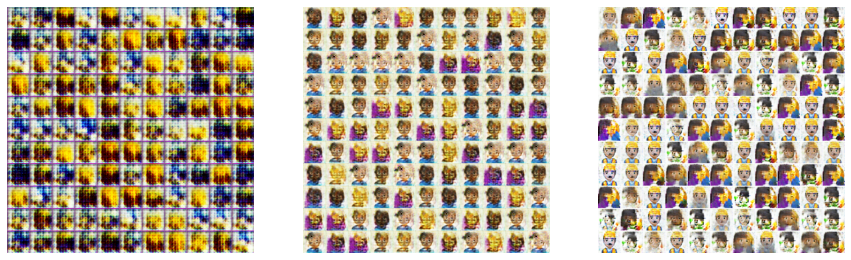

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
img = mpimg.imread(BASE_DIR + 'Samples/improved_generated_image_200.png')
img2 = mpimg.imread(BASE_DIR + 'Samples/improved_generated_image_1600.png')
img3 = mpimg.imread(BASE_DIR + 'Samples/improved_generated_image_2500.png')
ax1.axis('off')
ax1.grid(b=None)
ax1.imshow(img)
ax2.axis('off')
ax2.grid(b=None)
ax2.imshow(img2)
ax3.axis('off')
ax3.grid(b=None)
ax3.imshow(img3)
plt.show()

## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis

In [ ]:
def save_samples_bonus(generated_images,step,save_at="Samples/Bonus/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'bonus_image_' + str(step) + '.png'))

In [ ]:
def load_data_training():
    base_dir = '/tmp/all_emojis/Train/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def load_data_test():
    base_dir = '/tmp/all_emojis/Test/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

In [ ]:
def gan_training_loop_bonus(intervals=200):
    # Setup Models here
    X_train = load_data_training() # Changed this
    X_train = normalize(X_train)
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(0, 1601): # Running for only 1600 Epochs
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here

            batch_x_real = X_train[index : index + BATCH_SIZE]

            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            batch_x_fake = GEN.predict_on_batch(z)

            batch_y_real = np.random.uniform(0.7,1.2,BATCH_SIZE)
            batch_y_fake = np.zeros(shape=(BATCH_SIZE,))

            disc_loss = (DIS.train_on_batch(batch_x_real, batch_y_real))[0]
            disc_loss += (DIS.train_on_batch(batch_x_fake, batch_y_fake))[0]
            
            epoch_disc_loss.append(disc_loss)
            
            z = np.random.normal(0, 1, size =(BATCH_SIZE,NOISE_DIM))
            if np.random.uniform(0,1) > 0.05:
              gen_loss =  (DCGAN.train_on_batch(z, batch_y_real))[0]
            else:
              gen_loss =  (DCGAN.train_on_batch(z, batch_y_fake))[0]

            epoch_gen_loss.append(gen_loss)

            if not (e % intervals):
                save_samples_bonus(batch_x_fake,e)

            progress_bar.update(i+1)
        if not (e % intervals):
            # Save weights here
            DIS.save_weights(BASE_DIR + 'Discriminator/' + 'bonus_model_' + str(e) + '.hdf5') # Changes here
            GEN.save_weights(BASE_DIR + 'Generator/' + 'bonus_model_' + str(e) + '.hdf5')
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [ ]:
DB_Loss, GB_Loss = gan_training_loop_bonus()

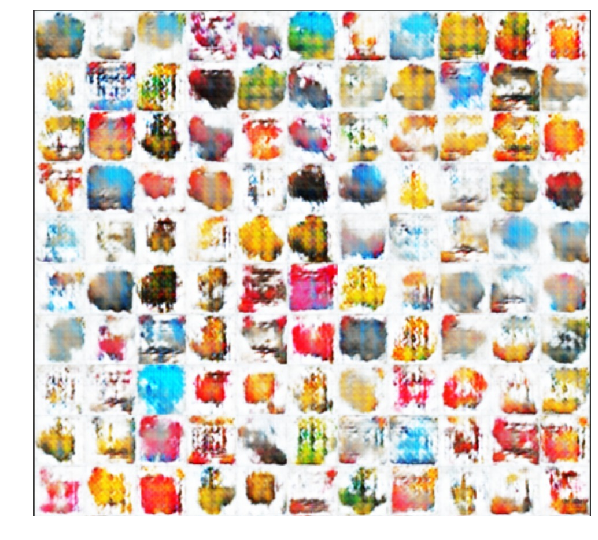

In [1]:
plt.figure(figsize=(10,10))
img = mpimg.imread(BASE_DIR + 'Samples/Bonus/bonus_image_1600.png')
plt.axis('off')
plt.grid(b=None)
plt.imshow(img)

### **Bonus Analysis**
As we can see in the image above our emojis arent as good as the Apple emojis, this is probably because we filtered the Apple emojis one where the images had face cenetered emojis only thus there was much better learning for the generator. Here where we are using all the emojis they are all of different shapes and sizes and categories which is why we can see there isn't a good result and all just mosly haphazard colours everywhere.

P.S I know the training isnt shown here but I was doing it in colab and after i got my results I accidentally ran the cell again so I had to interupt execution. Took this image out of the samples

P.P.S I didnt know what to do with the test data as we needed to predict on noise so i just ran these on training data. But i need the bonus marks please :'(

__The End__